# Week Four - Fitting Data: Parameter Estimation Using iminuit

<hr style="border:2px solid gray">

# Outline <a id='outline'></a>
1. [Section One: Interpolation](#section-1)
    1. [Linear Interpolation](#li)
    1. [Cubic Spline](#cs)
1. [Section Two: iminuit](#section-2)
1. [Section Three: Using iminuit](#ui)
    1. [The Basics](#tb)
    1. [Gradient Descent](#gd)
    1. [The Minuit object](#tmo)
    1. [Parameter Uncertainties, Covariances, and Confidence Intervals](#pucaci)
    1. [Maximum-likelihood fits](#mlf)

In data science, you will often be required to fit a curve to a set of data, because you want to interpolate between the data points you have, parameterize it, or extract some physical value from the data you have taken with associated uncertainty. This notebook serves as an introduction to some of these methods.

<hr style="border:2px solid gray">
<a name="section-1"></a>

## Section One: Interpolation  <a id='i'></a>

A curve of best fit is a function which tries to minimise the distance between it and all od the data points. This is by minimising the error. A simple method to create one is using linear interpolation. Although you can write a linear interpolation algorithm, there is a built-in option is available in `scipy`. 

## Linear Interpolation <a id='li'></a>

Linear interpolation gives a **line of best fit**, which is a generalisation of a curve of best fit and is best used on linear data. 

Here is a simple example of using linear interpolation. After performing this, we visualise it and show a distribution of the errors: 

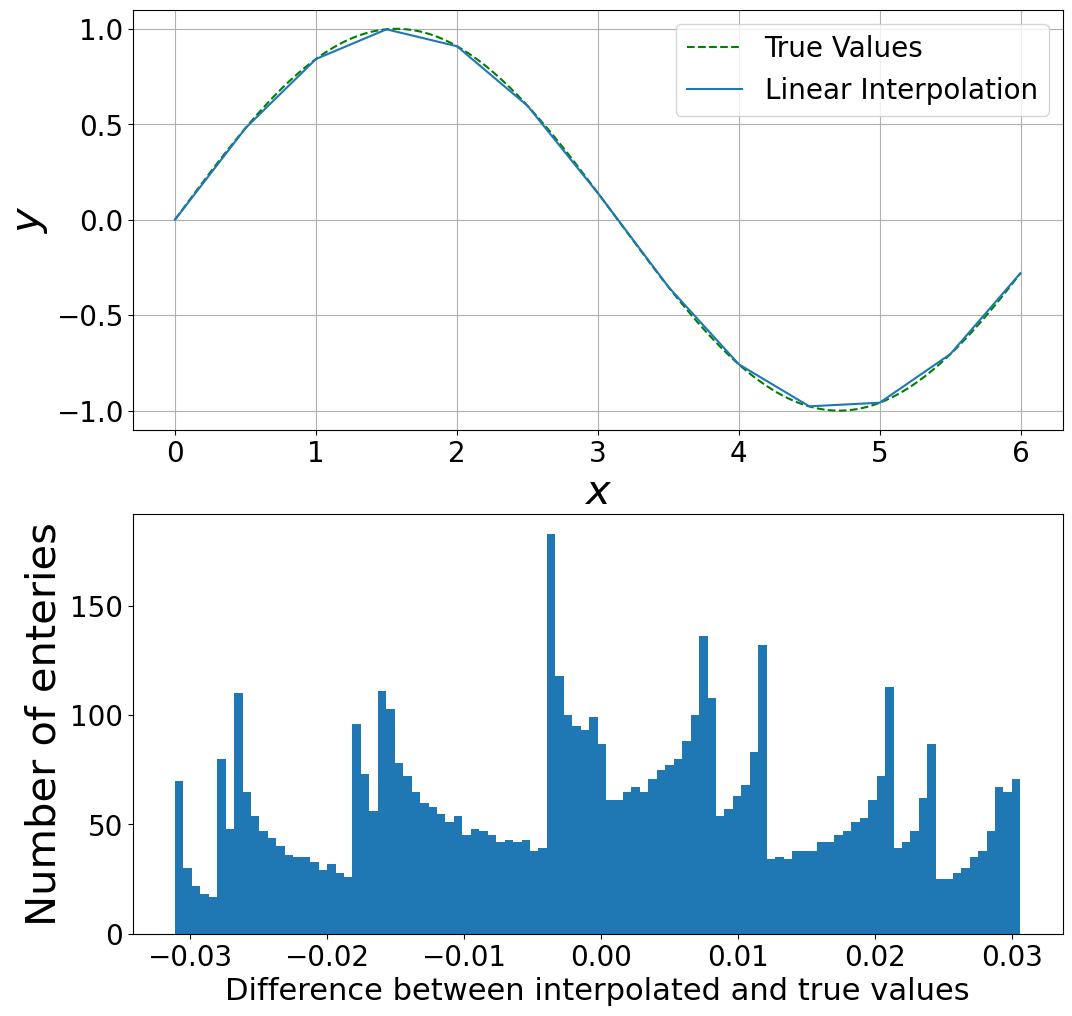

In [5]:
import numpy as np
import scipy as sp
import pylab as plt

x=np.arange(0, 6.5, 0.5) #We go to  6.5 to ensure that we get to 6
y=np.sin(x)

#Finer binned version for comparison
xf=np.arange(0, 6, 0.001) 
yf=np.sin(xf)


fig, axs= plt.subplots(2, figsize=(12, 12))

axs[0].plot(xf, yf, "g--",label="True Values")
axs[0].set_xlabel("$x$", fontsize=30)
axs[0].set_ylabel("$y$", fontsize=30)
axs[0].tick_params(labelsize=20)
axs[0].grid()


#Linear 1D interpolation, where we are given the predicted values, f
f=np.interp(xf, x, y)

# f is an array containing all predicted values of y for a given array of x values
axs[0].plot(xf, f, label="Linear Interpolation")

axs[0].legend(loc="upper right", prop={'size': 20})


#now lets histogram the differences.
ydiff=yf-f
axs[1].hist(ydiff, bins=100)
axs[1].set_xlabel("Difference between interpolated and true values", fontsize=22)
axs[1].set_ylabel("Number of enteries", fontsize=30)
axs[1].tick_params(labelsize=20)
#plt.xlim([-0.04,0.04])

plt.show()

As we can see here the differences are quite large, which can cause errors in predictions of data. There is also a structure in the differences. The interpolation struggles most where the graph is most curved (at the peak and trough) however does quite well at the points of maximum gradient. This could cause a systematic error in predicting future values

SPLINES(?)

<hr style="border:2px solid gray">

# iminuit [^](#index) <a id='im'></a>

One of the most important tasks in data analysis is fitting a model to your data. This is often from a well defined distribution, such as a gaussian or Poisson distribution. This can also be non probabilistic functions, such as the sinusodial function above. In the process of fitting the model, the error from your predictions to your training outputs should be minimised. When measuring physical quantities, the **uncertainty** of the measurement is paramount to analysis . 

Scipy has a series of functions for fitting data in scipy.optimize. However, we tend to use more advanced packages, such as [minuit](https://root.cern.ch/download/minuit.pdf) developed by CERN. This is written in C++ and wrapped in python as [iminuit](https://iminuit.readthedocs.io/en/stable/).

`iminuit` has some fantastic [tutorials](https://iminuit.readthedocs.io/en/stable/tutorials.html) on their website.

<hr style="border:2px solid gray">

# Using iminuit <a id='ui'></a>

## The Basics <a id='tb'></a>

You will learn basic usage of iminuit and how to approach standard fitting problems.

`iminuit` is a Python frontend to the Minuit library in C++, an integrated software that combines a local minimizer, called Migrad, which uses the method of **gradient descent** and **Newton's method** and two error calculators, called Hesse and the Minos. 

The basic idea is you provide an analytical function, which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from an initial guess. In that regard, iminuit minimizer is like other local minimizers, like those in scipy.optimize.

In addition, iminuit has the ability to compute **uncertainty estimates** for **model parameters**. iminuit was designed to solve statistics problems, where uncertainty estimates are an essential part of the result. The two ways of computing uncertainty estimates, Hesse and the Minos, have different advantages and disadvantages.

??An important feature of iminuit is that it uses **introspection** to detect the parameter names of your function. This is very convenient, especially when you work interactively in a Jupyter notebook. It also provides special output routines for Jupyter notebooks to pretty print the fit results, as you will see below.?? NOT TOO SURE WHAT THIS MEANS

## Gradient Descent [^](#index) <a id='gd'></a>
    
For functions with more than one variable, we can use a gradient descent algorithm to find minima and maxima with the ultimate goal being to minimising something called the **cost function** (which we will see more of next week). This relies on the first derivative to find the best direction to step in to find the extremum.

First, we initialise the algorithm at some set of values for the parameters $\boldsymbol{\theta}_{init}$. We then calcualte the gradient of the negative log-likelihood $q$, $\nabla q\rvert_{\boldsymbol{\theta}_{init}}$  at the initial point. The gradient defines a direction in which the negative log-likelihood changes most rapidly. This is the optimal direction to search for a smaller value of $q$.

Mathematically this looks like
$$
\begin{align*}
\nabla q\rvert_{\boldsymbol{\theta}_{init}} &=   
        \begin{bmatrix}
           \frac{\partial q}{\partial \theta_{1}} \\
           \frac{\partial q}{\partial \theta_{2}} \\
           \vdots \\
           \frac{\partial q}{\partial \theta_{n}}
        \end{bmatrix}_{\boldsymbol{\theta}=\boldsymbol{\theta}_{init}}
\end{align*}   
$$

In the case of finding a minimum, we want to *decrease* $q$, so we need to move against thw direction of the gradient. We step along the negative gradient direction until we find a minimum - i.e we pick a step size $h$ and keep adding it to the initial point until the value of $q$ stops decreasing or gets to some threshold which we pick, 

$$
\boldsymbol{\theta}_{k} = k\times h - \nabla q\rvert_{\boldsymbol{\theta}_{init}} 
$$
where $k$ is the number of steps.

?GRAPHICAL REPRESENTATION OF GRADIENT DESCENT?

### Quick start ###

In this section, we look at a simple case where a straight line will be fitted to a scattered $(x,y)$ dataset. A line has two parameters, which we call $(a, b)$ (aka $y=bx+a$). Here we show all of the steps to get you started. In later sections we will revisit the steps in more detail.

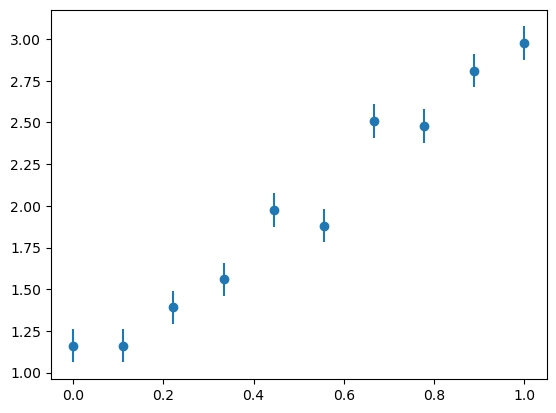

In [6]:
from matplotlib import pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares #Importing cost function to fit, the LeastSquares function

#Our straight line model 
def line(x, a, b):
    return  b*x + a

# generate random toy data with random offsets in y
np.random.seed(1) #Ensures the 'toy data' is the same each time
x = np.linspace(0, 1, 10)
yerr = 0.1  # could also be an array
y = line(x, 1, 2) + yerr * np.random.randn(len(x))

plt.errorbar(x, y, yerr, fmt="o");

To estimate the parameters $a$ and $b$ from this data, we need to a minimize a suitable cost function. The cost function must be **twice differentiable** and have a **minimum** at the optimal parameters. We use the method of least-squares here, whose cost function computes the sum of squared residuals between the model and the data. The task of iminuit is to find the minimum of that function. Let’s do it: